### Preprossesing of GCaMP6s dataset

Here perform preprocessing of publicly available data. 
The raw data can be obtained from: https://crcns.org/data-sets/methods/cai-1/about-cai-1

In [1]:
import sys
import os

import numpy as np
import pickle 
import time 
import scipy.io

from operator import itemgetter
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def percentile_trend(trace,wwidth,percentile):
    """
    Calculates a trend for every timepoint by looking at a window around that time, and calculating the given percentile.
    """
    trend = np.zeros_like(trace)
    for t in range(len(trace)):
#         window = np.max([0,t-wwidth/2]).astype(int),np.min([len(trace),t+wwidth/2]).astype(int)
        trend[t] = np.percentile(trace[window[0]:window[1]],5)
    return trend

def dFoF(trace,wwidth,percentile):
    """
    Calculates Δf/f using the percentile trend as base
    """
    restrace = np.zeros_like(trace)
    for t in range(len(trace)):
        window = np.max([0,t-wwidth/2]).astype(int),np.min([len(trace),t+wwidth/2]).astype(int)
        trend = np.percentile(trace[window[0]:window[1]],percentile)
        restrace[t] = (trace[t]-trend)/trend
    return restrace

In [3]:
n_cells = 9
data_folder = os.getenv('HOME')+'/data'

traces_raw = [[] for x in range(n_cells)]
spikes_raw = [[] for x in range(n_cells)]
npil_raw = [[] for x in range(n_cells)]

traces_prep = [[] for x in range(n_cells)]

fps =  [[] for x in range(n_cells)]
spikefps = 300

cai_mat = [[] for x in range(n_cells)]
for i in os.listdir(data_folder+'/GCaMP6s_9cells_Chen2013'):    
    if i[-4:] == '.mat':
        mat = scipy.io.loadmat(data_folder+'/cai-1/GCaMP6s_9cells_Chen2013'+'/'+i, squeeze_me = True, struct_as_record = False)['obj']
        if i[:19] == 'data_20120417_cell1': cai_mat[0].append(mat) 
        if i[:19] == 'data_20120417_cell3': cai_mat[1].append(mat)
        if i[:19] == 'data_20120417_cell4': cai_mat[2].append(mat)
        if i[:19] == 'data_20120417_cell5': cai_mat[3].append(mat)
        if i[:19] == 'data_20120627_cell2': cai_mat[4].append(mat)
        if i[:19] == 'data_20120627_cell3': cai_mat[5].append(mat)
        if i[:19] == 'data_20120627_cell4': cai_mat[6].append(mat)
        if i[:19] == 'data_20120515_cell1': cai_mat[7].append(mat)
        if i[:19] == 'data_20120416_cell1': cai_mat[8].append(mat)

We store binned spikes at a higher frequency (300Hz) so we have the freedom to resample to different frequencies later

In [4]:
fps =  [[] for x in range(n_cells)]

for i in range(n_cells):
    for data in cai_mat[i]:
        
        fluor_data = data.timeSeriesArrayHash.value[0].valueMatrix
        fluor_time = data.timeSeriesArrayHash.value[0].time
        npil_data = data.timeSeriesArrayHash.value[1].valueMatrix
        spike_bool = data.timeSeriesArrayHash.value[4].valueMatrix
        spike_time = data.timeSeriesArrayHash.value[4].time
        spike_ts = spike_time[np.where(spike_bool == 1)]*1000   
        fps_curr = 1/np.mean(np.diff(fluor_time))
        bins = (np.arange(1000*fluor_time[0]-1000/fps_curr,1000*fluor_time[-1],(1000/spikefps)))
        
        spikes_raw[i].append(np.histogram(spike_ts, bins)[0])
        traces_raw[i].append(fluor_data)   
        npil_raw[i].append(npil_data)   
        fps[i].append(fps_curr)

for i in range(len(fps)):
    fps[i] = np.mean(fps[i])

Our preprocessing includes the following steps:
    * Substract neuropil contamination
    * Calculate a percentile trend
    * Calculate Δf/f using the percentile trend as base fluorescence
    
To visualize this process we show the raw trace, the true spikes, the neuropil, the trace after substracting the neuropil (weighted by 0.7) and the trend.

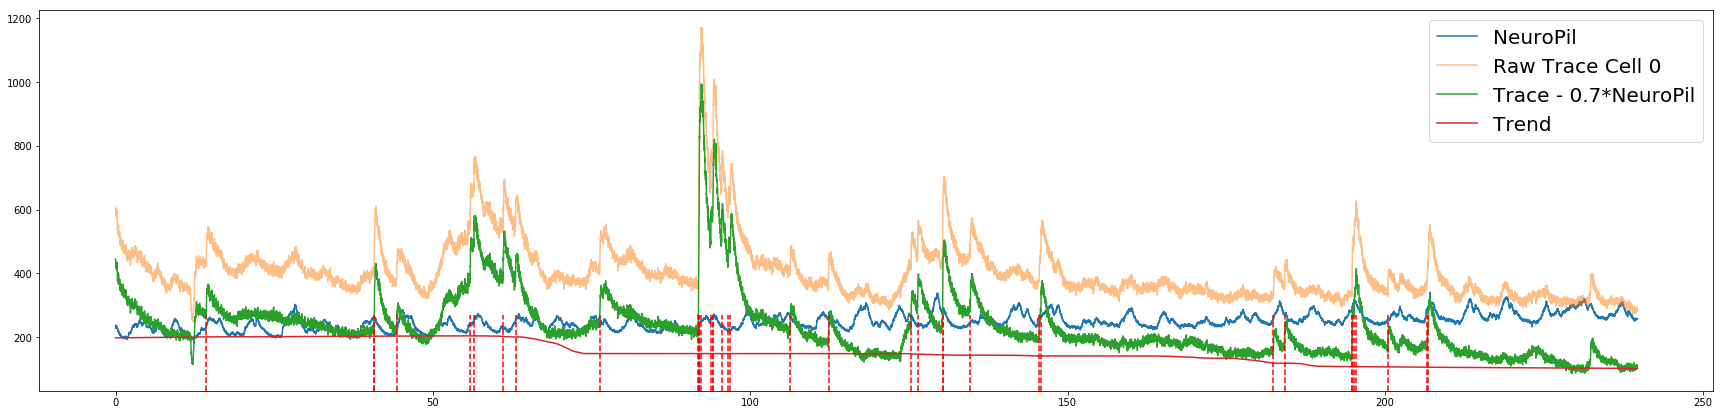

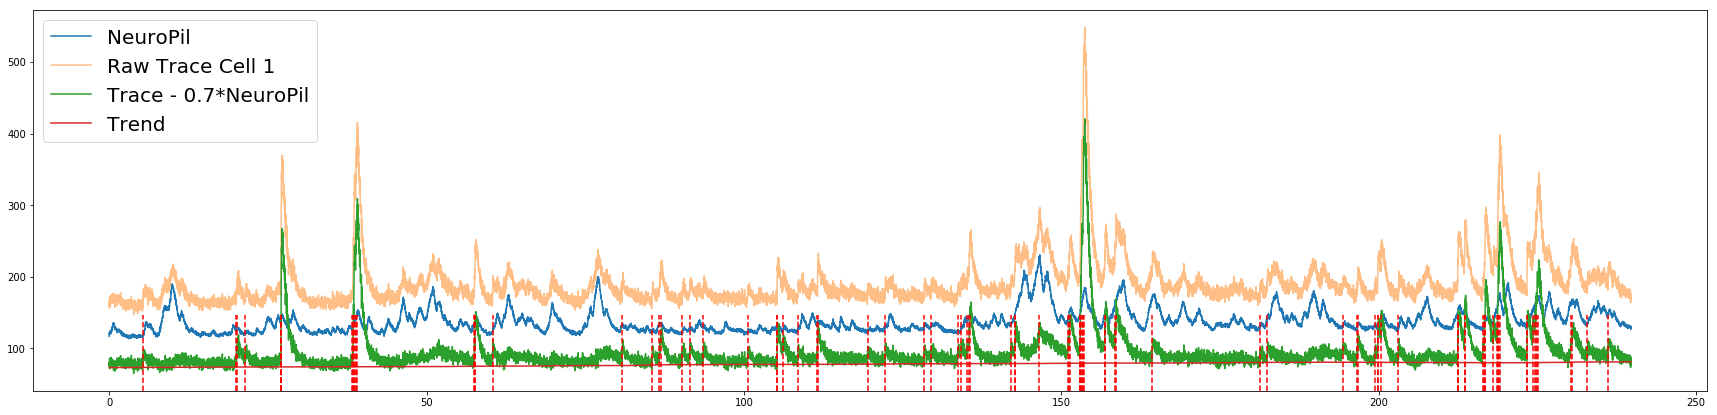

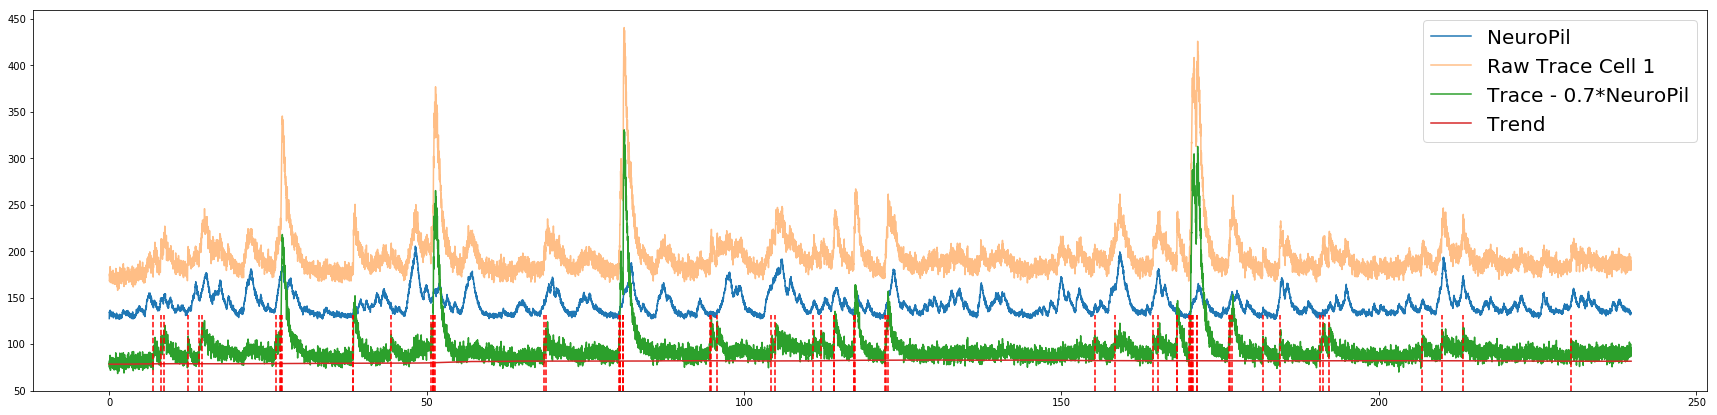

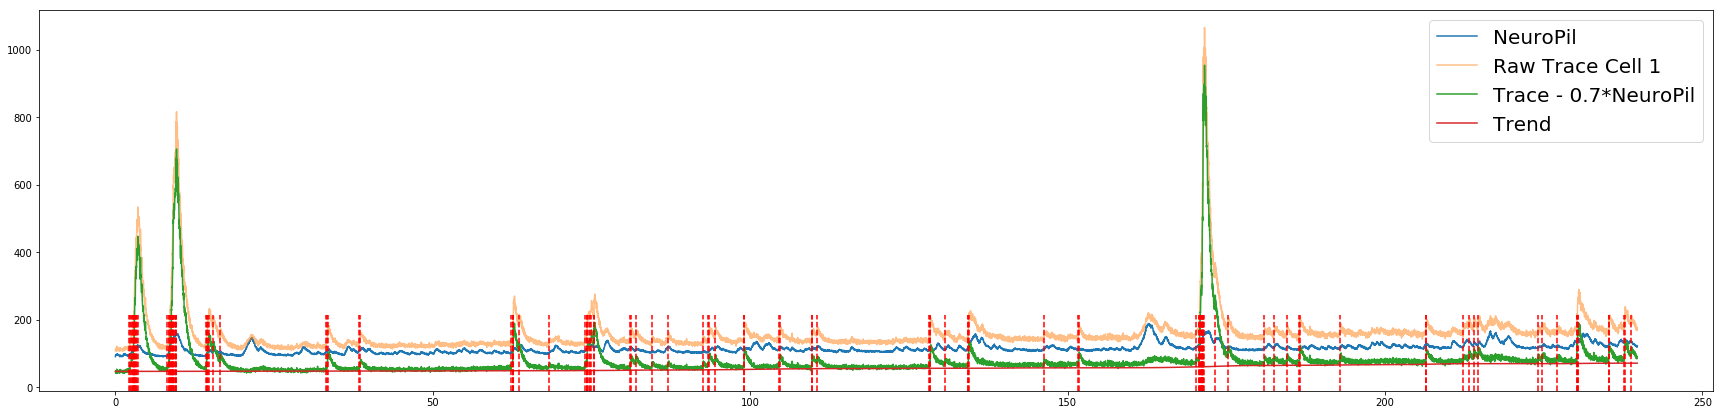

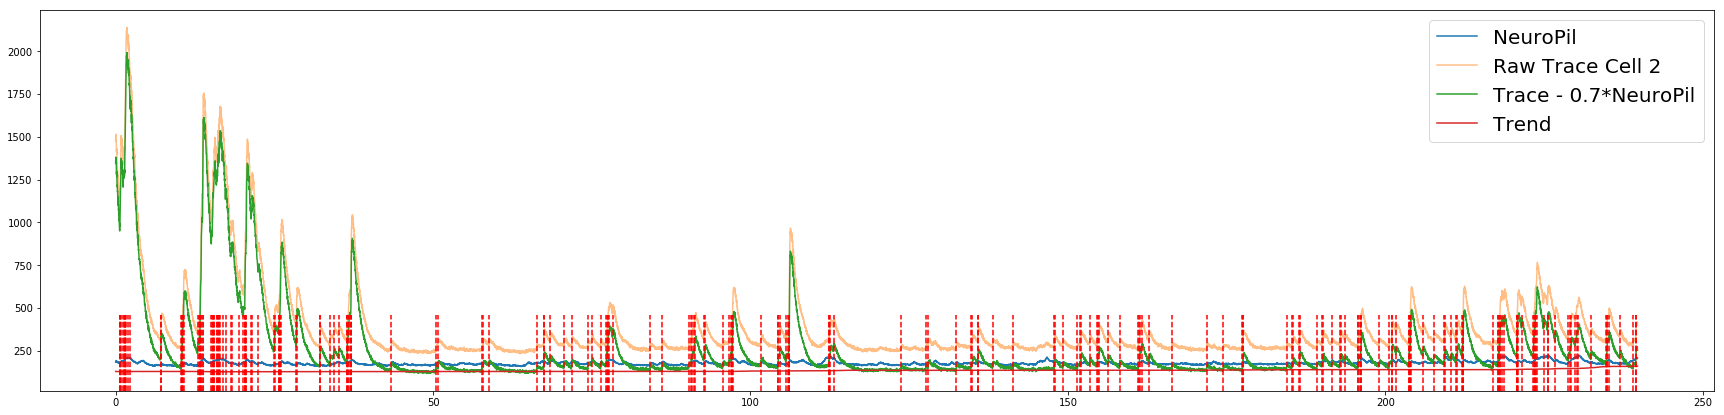

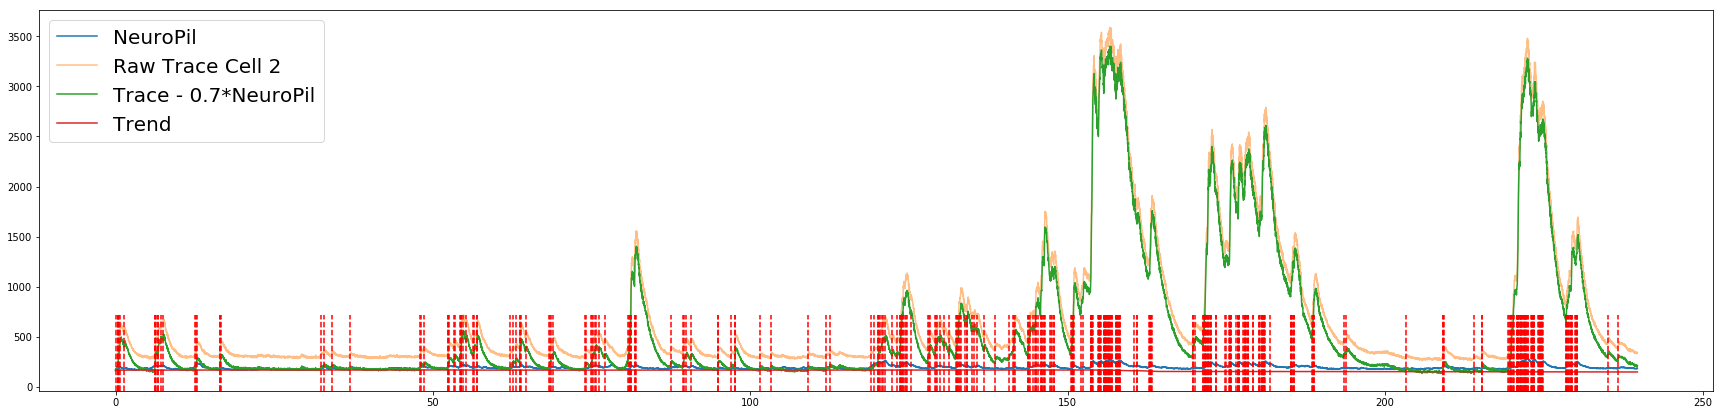

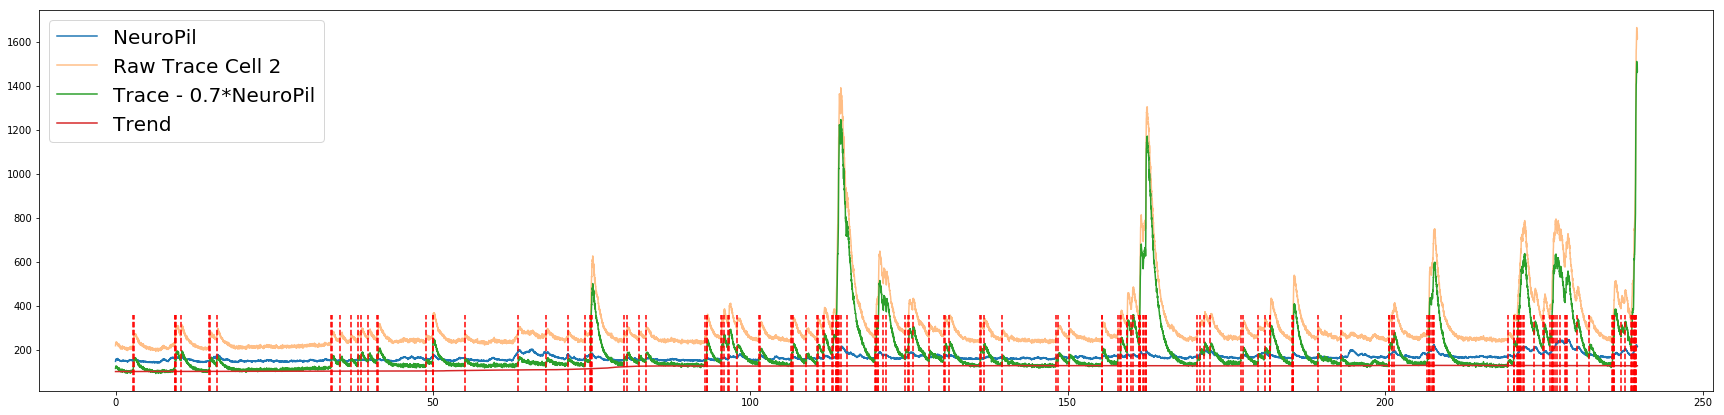

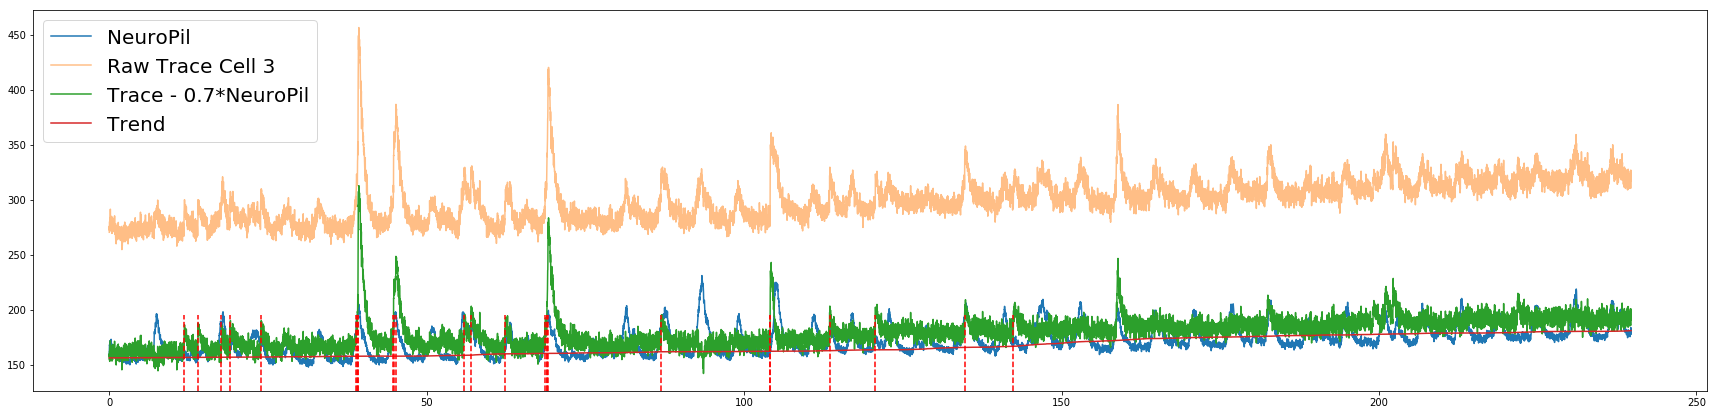

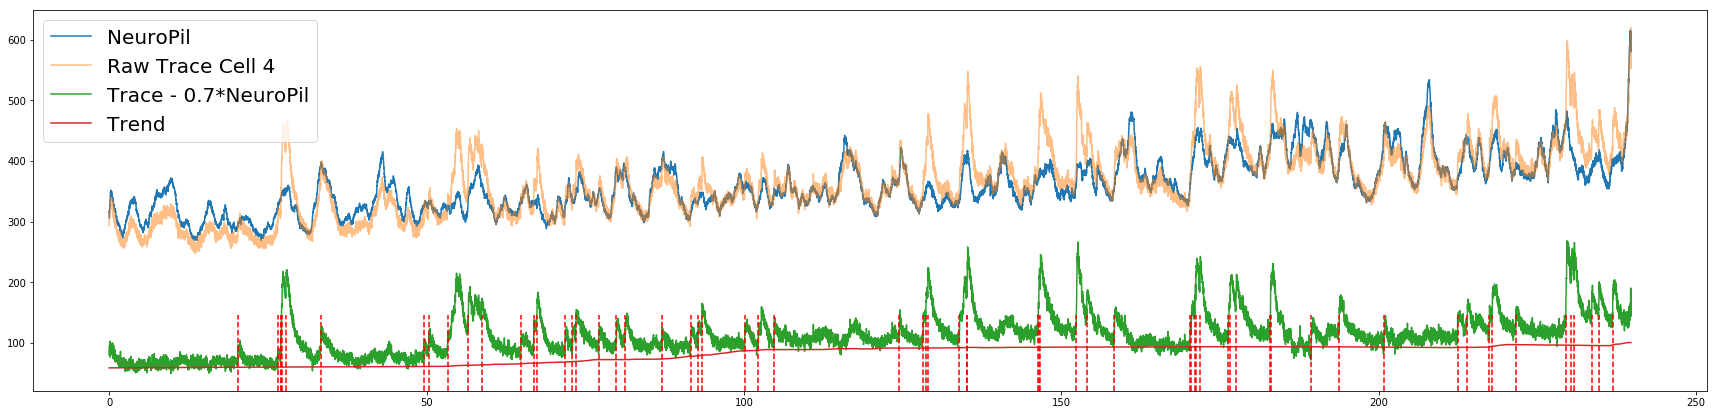

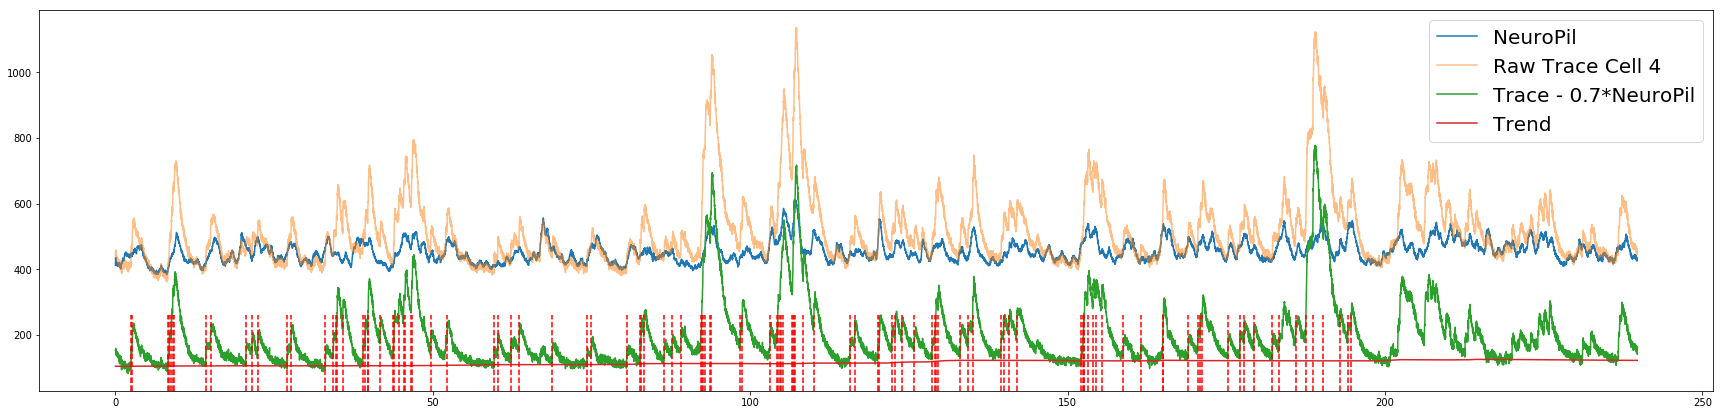

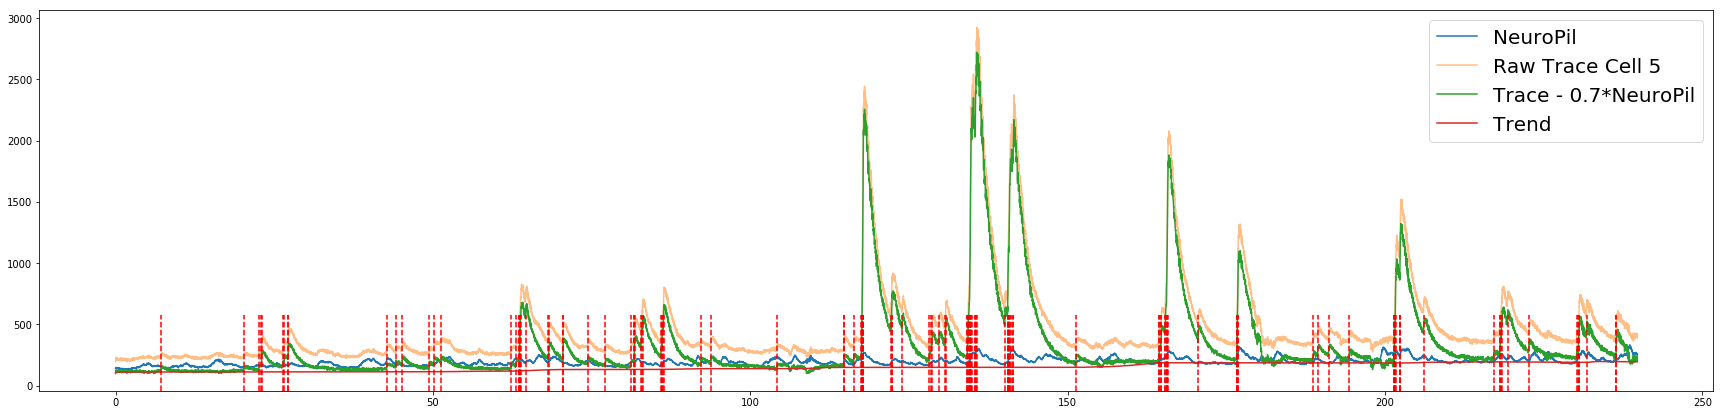

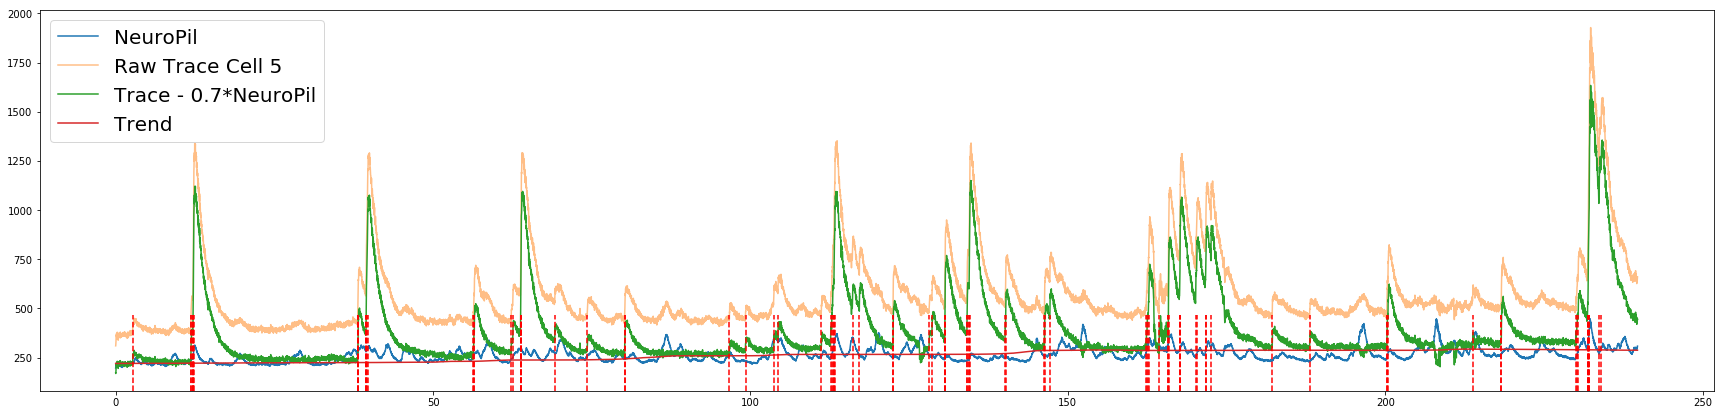

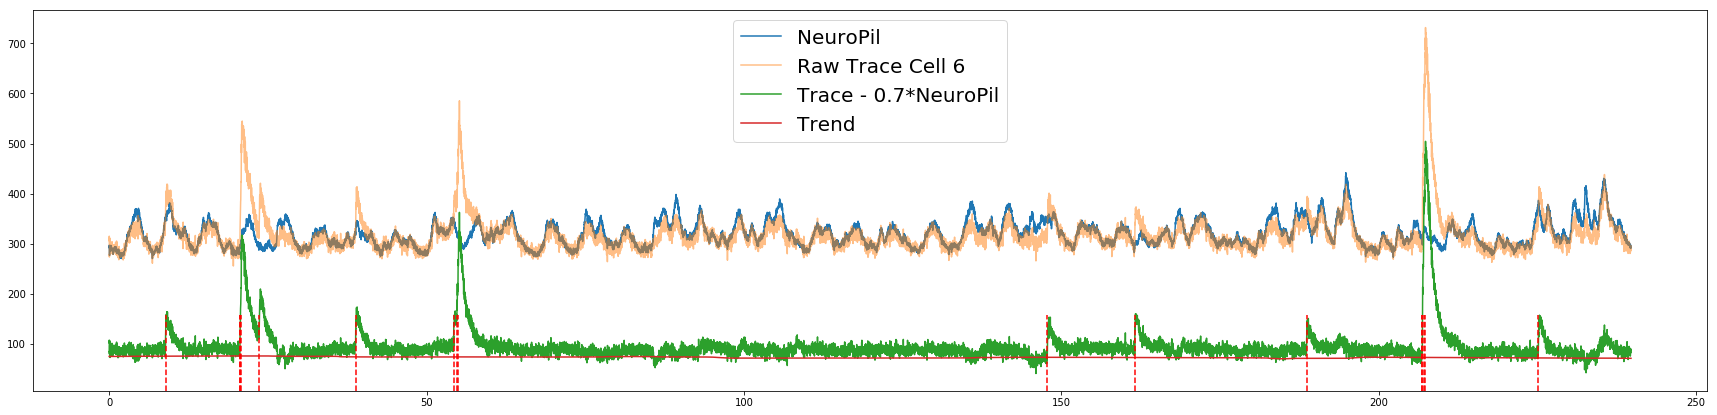

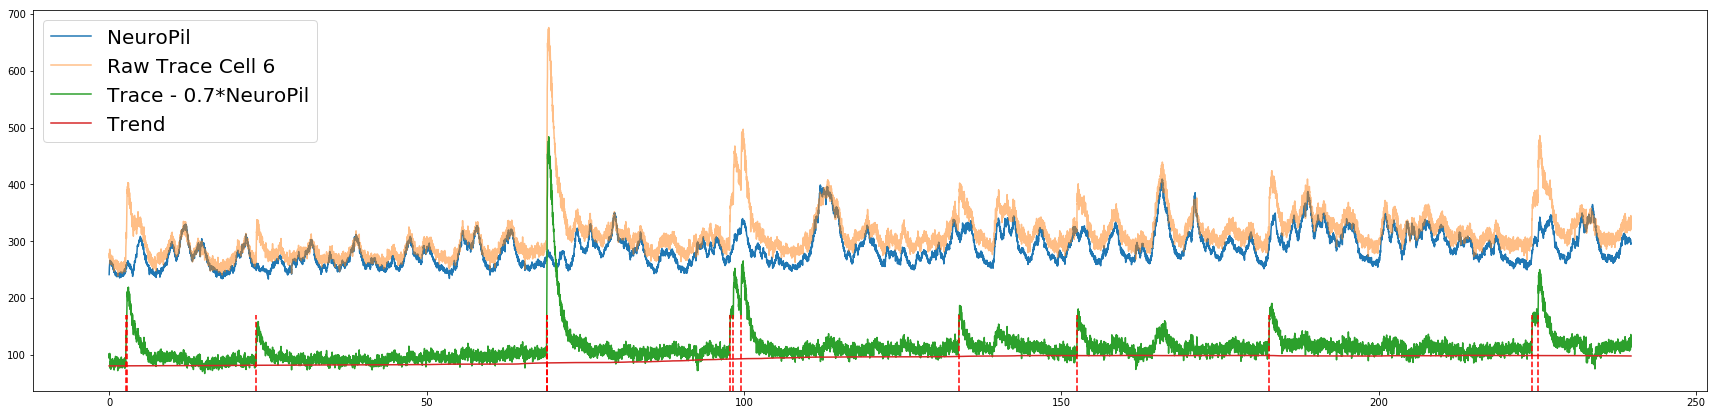

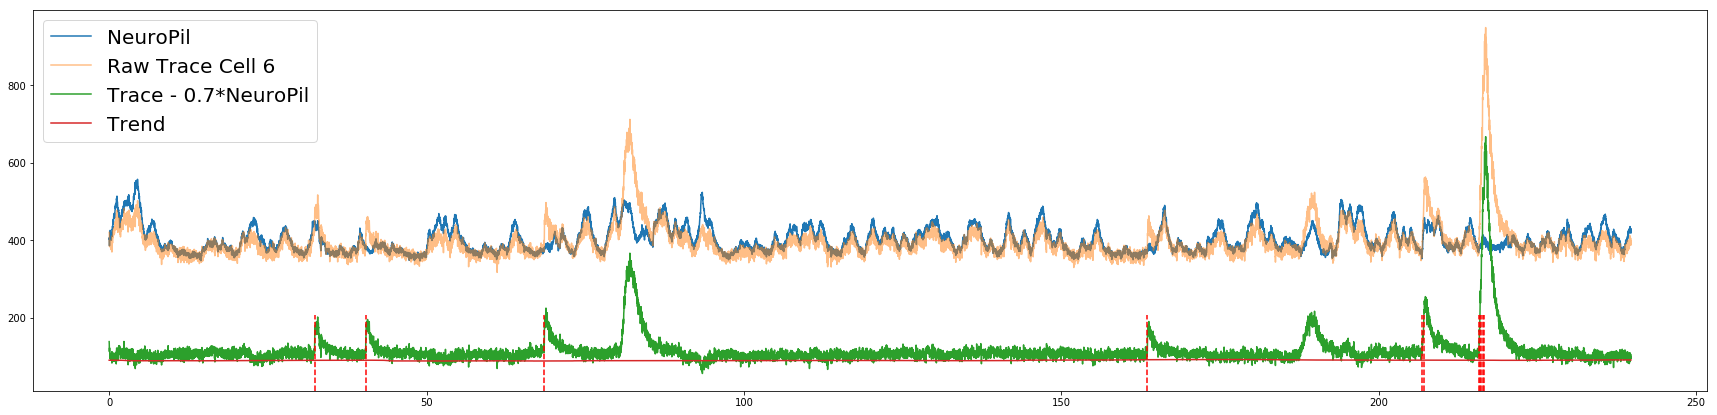

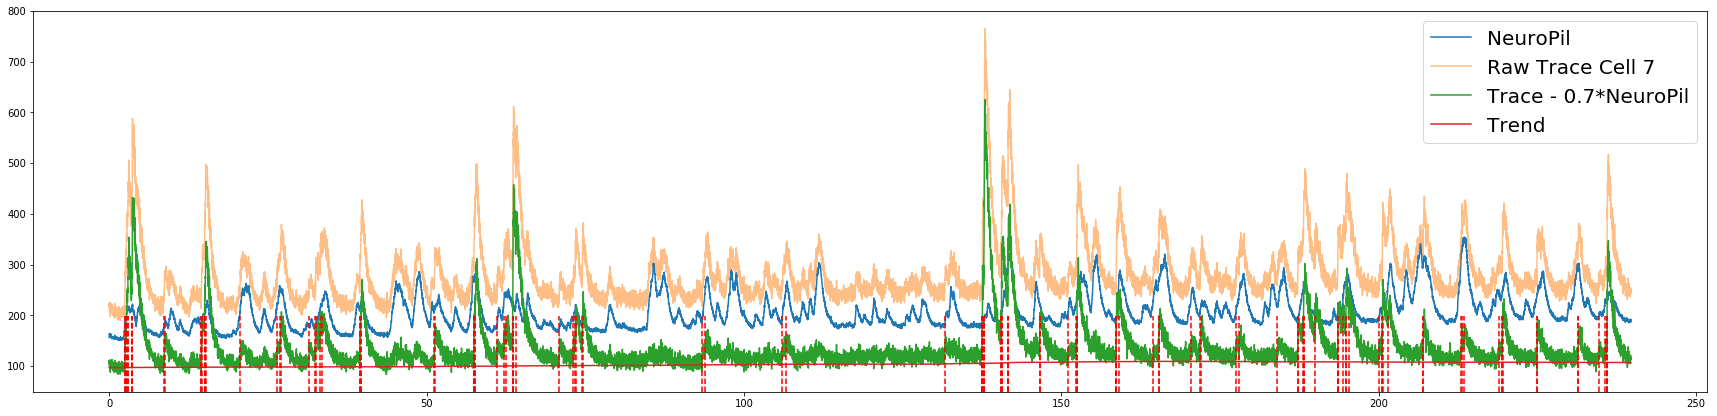

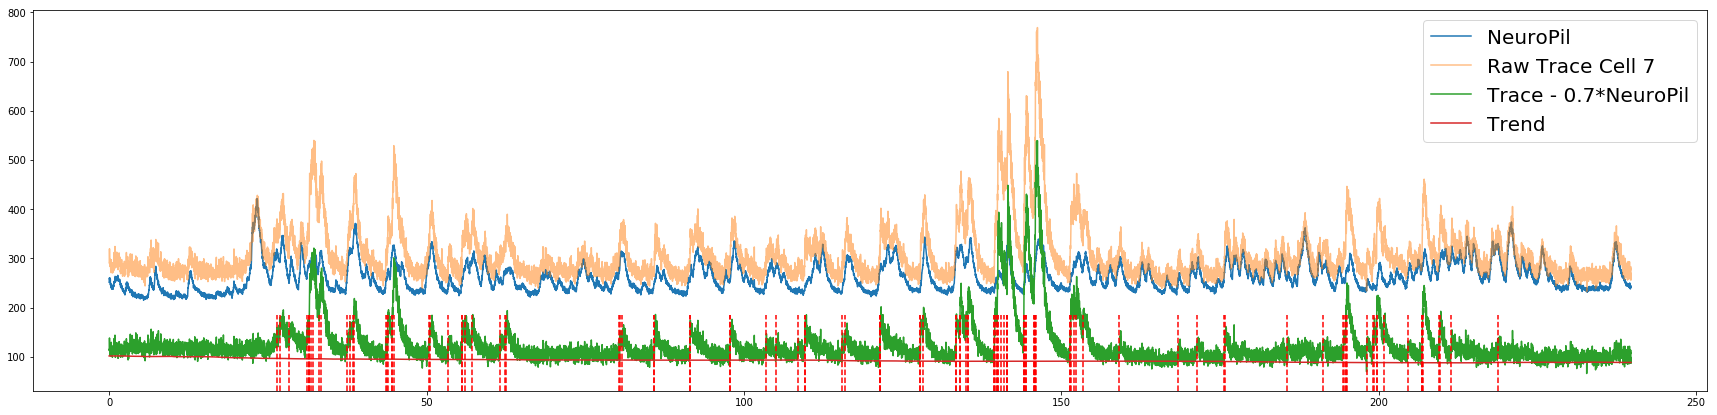

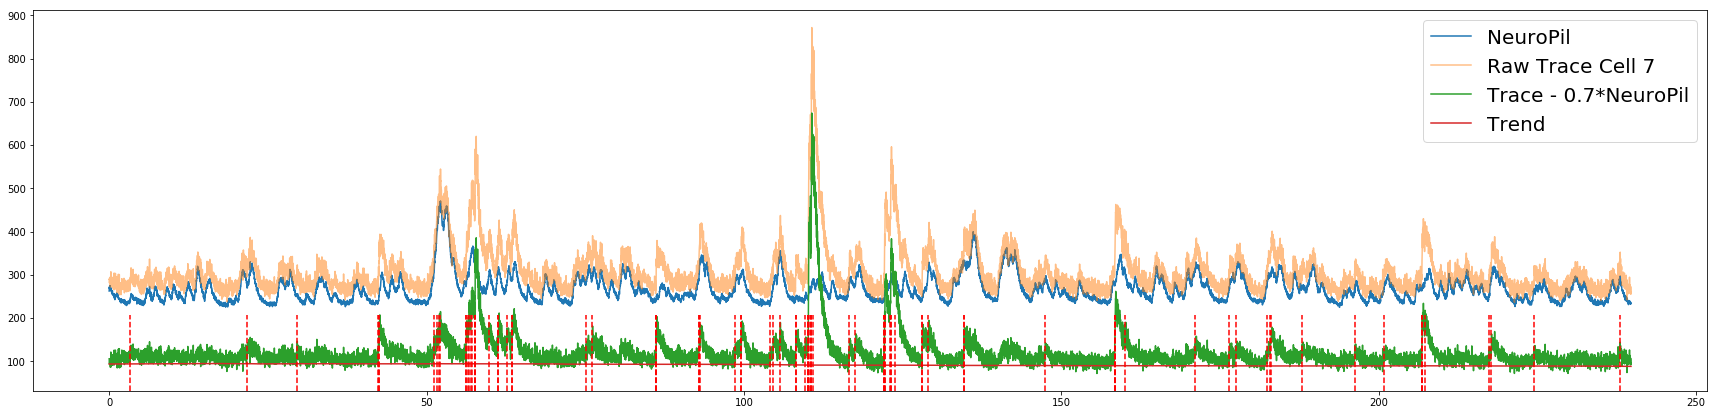

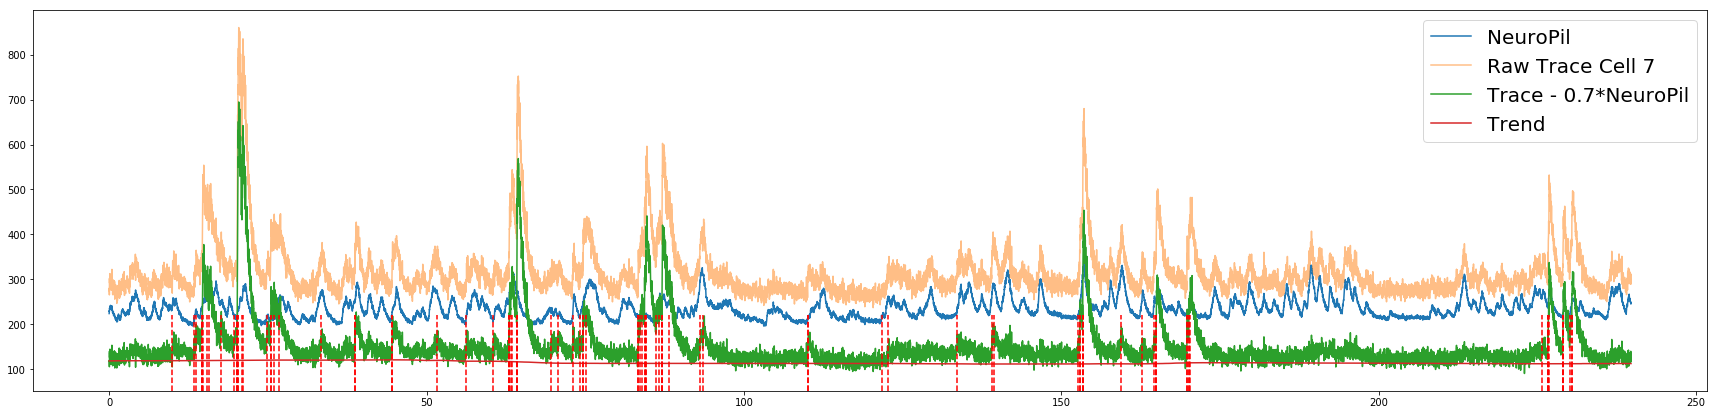

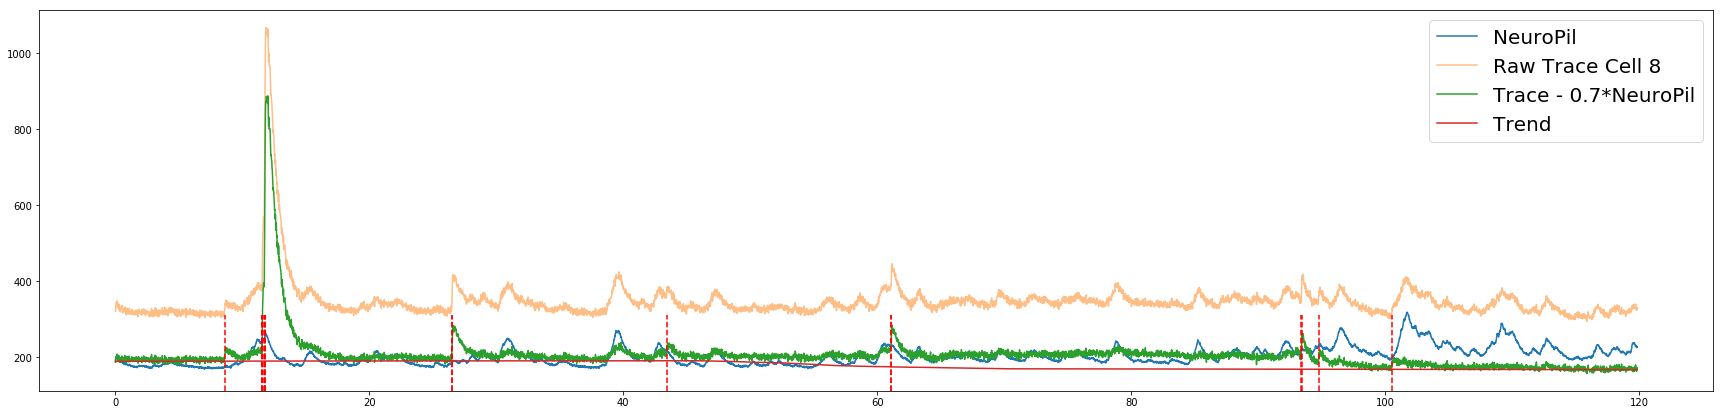

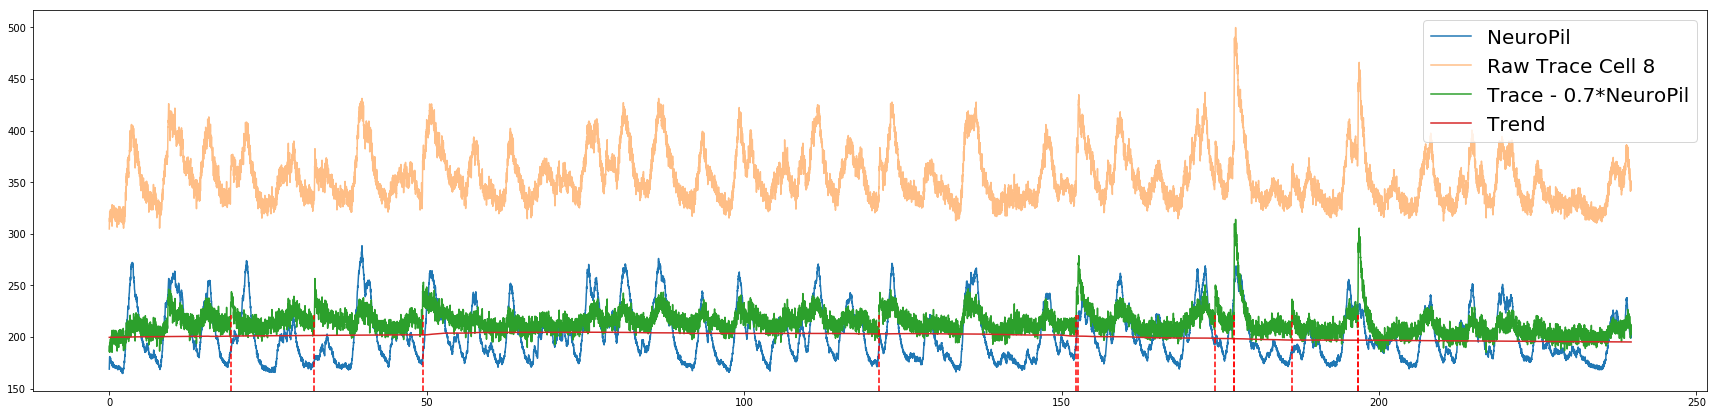

In [5]:
for i in range(len(traces_raw)):
    for j in range(len(traces_raw[i])):        
        
        trace = traces_raw[i][j]
        trace = dFoF(traces_raw[i][j] - 0.7*npil_raw[i][j],6000,5)
        traces_prep[i].append(trace)
        
        tf = np.arange(len(traces_raw[i][j]))*1/fps[i]    
        plt.figure(figsize=(30,7))
        
        plt.plot(tf, npil_raw[i][j], label = 'NeuroPil') 
        plt.plot(tf, traces_raw[i][j] , label = 'Raw Trace Cell '+str(i), alpha = 0.5) 
        plt.plot(tf, traces_raw[i][j] - 0.7*npil_raw[i][j], label = 'Trace - 0.7*NeuroPil')
        plt.plot(tf, percentile_trend(traces_raw[i][j] - 0.7*npil_raw[i][j],6000,5),label = 'Trend')

        plt.legend(fontsize = 20)
        for s in np.where(spikes_raw[i][j][:] != 0)[0]:   
            if spikes_raw[i][j][s] > 4: plt.axvline(s*1/spikefps, 0, 1, color='red', linestyle='dashed')             
            else: plt.axvline(s*1/spikefps, 0, spikes_raw[i][j][s]*0.2, color='red', linestyle='dashed')  
        plt.show()

In [6]:
data_dict = {'traces': traces_prep, 'spikes': spikes_raw, 'fps' : fps, 'spike_fps': spikefps}

with open('gc6s_prepped.pkl', 'wb') as f:
    pickle.dump(data_dict, f, pickle.HIGHEST_PROTOCOL)